# Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps

https://proceedings.mlr.press/v202/cuturi23a.html

In [1]:
import jax
import jax.numpy as jnp
from jax import lax 
from jax import vmap

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from tqdm import tqdm

#### Monge Optimal Transport Problem

We consider a translation-invariant cost function $c(x,y) := h(x-y)$ where $h : \mathbb{R}^{d} \longrightarrow \mathbb{R}$. The Monge problem is the following optimisation problem :
$$ T^{*} := \arg\limits_{T \sharp \mu = \nu} \inf { \int_{\mathbb{R}^{d}} h(x - T(x)) d\mu(x) } $$
With $\forall A \subset \mathbb{R}^{d}, \: T \sharp \mu(A) = \mu(T^{-1}(A))$ 

In our case, we will consider $h$ of elastic type with the following form : $\forall z \in \mathbb{R}^{d}, \: h(z) := \frac{1}{2} \|z\|^2 + \tau(z)$ where $\tau$ is a function whose proximal operator is well defined. 

The aim of the paper is to establish a consistant estimator $T_{h,\varepsilon}$ of $T^{*}$. In this tutorial, we will restrict ourself to the following functions $\tau$ which are pretty simple and implemented (with their gradient, proximal operator, ...) optimally in OTT JAX :

1) Euclidian Case without any regularization : $\tau(z) = 0$, associated cost function $h$ will be `SqEuclidean`

2) $\ell_1$ regularization : $\tau(z) = \gamma \| z \|_{1}$, associated cost function $h$ will be `ElasticL1`

3) Soft Thresholding Vanishing Shrinkage (STVS) : $\tau(z) = \gamma^{2} \mathbf{1}_{d}^{T}\left( \text{asinh}(\frac{z}{2\gamma}) + \frac{1}{2} - \frac{1}{2}e^{-2\text{asinh}(\frac{z}{2\gamma})} \right)$, associated cost function $h$ will be `ElasticSTVS`

4) $k-$ Overlap : $\tau(z) = \| z \|_{\text{ov}k}$, associated cost function $h$ will be `ElasticSqKOverlap`

##### In this tutorial, we wanted to explain some functions of OTT JAX and to illustrate this, we wanted to reproduce the Synthetic experiments in the case of Constant sparsity-pattern which has been studied in the article

We consider the following distributions: 

- $ \mu = \mathcal{U}_{[0,1]^d}$ ;
- For an integer $ s<d $, we set $ \nu = T^\star_s \sharp \mu \, , \, T^\star_s(x) = [\exp(x_1), \ldots, \exp(x_s), x_{s+1}, \ldots, x_d] $ where the map $ T^\star_s $ acts on coordinates independently.

First, we generate $n$ i.i.d. samples $x_i$ from $\mu$, and $y_j$ from $\nu$ independently. The samples $y_j$ are obtained by first generating fresh i.i.d. samples $\tilde{x}_j$ from $\mu$ and then pushing them: $y_j := T^\star_s(\tilde{x}_j)$.

In [2]:
def map_constant_pattern(X,s) : 
    return jnp.concatenate((jnp.exp(X[:,:s]), X[:,s:]),-1)

def uniform_samples(n, d, key):
   return(jnp.asarray(jax.random.uniform(key,(n,d))))


def sample_data(n, d, s, type_transport):
   key=jax.random.PRNGKey(0)
   key_1, key_2 = jax.random.split(key)

   X = uniform_samples(n,d,key_1)
   X_tilde = uniform_samples(n,d,key_2)

   if type_transport == "constant_pattern" :
      T_star = map_constant_pattern(X, s)
      Y = map_constant_pattern(X_tilde, s)

   else : 
      T_star = map_dependent_pattern(X, s)
      Y = map_dependent_pattern(X_tilde, s)
   return(X, T_star, Y)


Here is what we obtain for $n = 100$, $d = 2$, $s = 1$

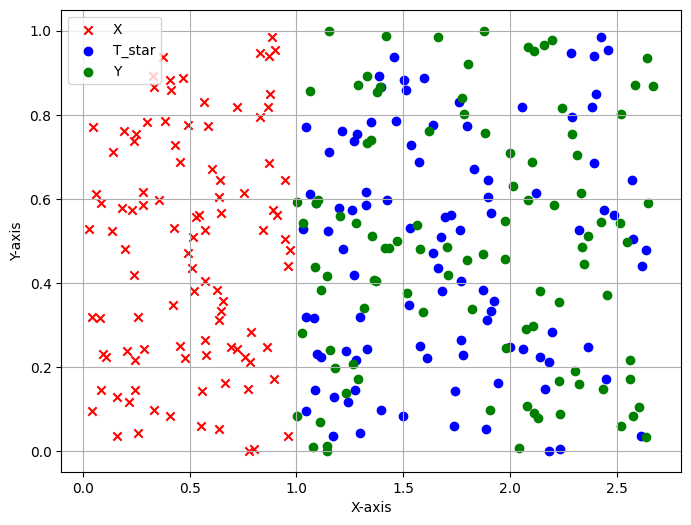

In [97]:
n = 100
d = 2 
s =1 

type_transport = "constant_pattern"

X, T_star, Y = sample_data(n, d, s, type_transport)

plt.figure(figsize=(8, 6))

plt.scatter(X[:,0], X[:,1], color='red', marker='x', label="X")


plt.scatter(T_star[:,0], T_star[:,1], color='blue', marker='o',label="T_star")


plt.scatter(Y[:,0], Y[:,1], color='green', marker='o',label="Y")

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.show()



One can show that to build $T_{h,\varepsilon}$, the only optimization problem we need to solve is the following one. This problem is known under the name of Dual Entropy-Regularized Optimal Transport Problem and the method we will use to solve it with OTT JAX is the Sinkhorn algorithm which is already implemented :
$$ f^{*} , g^{*} = \arg\limits_{f \in \mathbb{R}^{n} , g \in \mathbb{R}^{m}} \max \left\{ \left\langle f , \frac{\mathbf{1}_{n}}{n} \right\rangle + \left\langle g , \frac{\mathbf{1}_{m}}{m} \right\rangle - \varepsilon \left\langle e^{\frac{f}{\varepsilon}} , K e^{\frac{g}{\varepsilon}} \right\rangle \right\} $$
Where $K$ is the Kernel-Matrix defined by : $K_{i,j} := \left( \frac{ \exp\left( -h\left( x^{i} - y^{j} \right) \right) }{\varepsilon} \right)$ and $\left(x,y\right)$ the point cloud we will use

In [3]:
def run_experiment(X, Y, cost):
    #instantiate a PointCLoud geometry
    geom = ott.geometry.pointcloud.PointCloud(X, Y, cost_fn=cost)
    # Define a linear problem with that cost structure.
    ot_prob = linear_problem.LinearProblem(geom)
    # Create a Sinkhorn solver
    solver = sinkhorn.Sinkhorn()
    # The out object contains many things, among which the dual potentials 
    ot = solver(ot_prob)
    dual_potentials = ot.to_dual_potentials()

    return dual_potentials.transport(X)


In order to get the graphics presented in the paper, we will compute the Normalized MSE and the SE of our estimator, which are defined below :
$$ \mathbf{MSE}\left( T_{h,\varepsilon} \right) := \frac{1}{nd}\sum\limits_{i=1}^{n} \| T_{s}^{*}(x^{i}) - T_{h,\varepsilon}(x^{i}) \|^{2} $$
$$ \mathbf{SE}\left( T_{h,\varepsilon} \right) := \frac{ \sum\limits_{i=s+1}^{d} \Delta_{i}^{2} }{ \sum\limits_{i=1}^{d} \Delta_{i}^{2} } $$
With $\Delta := T_{h,\varepsilon}(x) - x$

In [4]:
def normalized_mse(y, y_pred) :
    return  (1/y.shape[1]) * jnp.mean(jnp.linalg.norm(y-y_pred,axis=1)**2)
    
def support_error(y_pred,x) :
    delta = y_pred -x
    return jnp.mean(jnp.sum(delta[:,s+1:]**2,axis=1) / (jnp.sum(delta**2,axis=1)))

In [5]:
def compute_metrics(costs, n, d, s):
    all_msse = []
    all_support_errors = []

    for cost in costs:
        X, T_star, Y = sample_data(n, d, s, "constant_pattern")
        transport = run_experiment(X, Y, cost)

        msse = normalized_mse(T_star, transport)
        all_msse.append(msse)

        error = support_error(transport,X)
        all_support_errors.append(error)

    return(all_msse,all_support_errors)

## Experiments with varying gamma

In [68]:
gammas = sorted([10**(j) * i for i in range(1,10) for j in range(-2,2)])

costs_L1 = [ott.geometry.costs.ElasticL1(scaling_reg=gamma, matrix=None, orthogonal=False) for gamma in gammas]
costs_STVS = [ott.geometry.costs.ElasticSTVS(scaling_reg=gamma, matrix=None, orthogonal=False) for gamma in gammas]
costs_L2 = [ott.geometry.costs.PNormP(2) for gamma in gammas]
costs_ovk_7 = [ott.geometry.costs.ElasticSqKOverlap(7, scaling_reg=gamma) for gamma in gammas]
costs_ovk_5 = [ott.geometry.costs.ElasticSqKOverlap(5, scaling_reg=gamma) for gamma in gammas]

In [69]:
n = 1000
d = 8
s=5

msse_L1_d_8, support_errors_L1_d_8 = compute_metrics(costs_L1, n, d, s)
msse_STVS_d_8, support_errors_STVS_d_8 = compute_metrics(costs_STVS, n, d, s)
msse_L2_d_8, support_errors_L2_d_8 = compute_metrics(costs_L2, n, d, s)
msse_ovk_7_d_8, support_errors_ovk_7_d_8 = compute_metrics(costs_ovk_7, n, d, s)
msse_ovk_5_d_8, support_errors_ovk_5_d_8 = compute_metrics(costs_ovk_5, n, d, s)

100%|██████████| 36/36 [01:30<00:00,  2.51s/it]


In [70]:
n = 1000
d = 20
s=5

msse_L1_d_20, support_errors_L1_d_20 = compute_metrics(costs_L1, n, d, s)
msse_STVS_d_20, support_errors_STVS_d_20 = compute_metrics(costs_STVS, n, d, s)
msse_L2_d_20, support_errors_L2_d_20 = compute_metrics(costs_L2, n, d, s)
msse_ovk_7_d_20, support_errors_ovk_7_d_20 = compute_metrics(costs_ovk_7, n, d, s)
msse_ovk_5_d_20, support_errors_ovk_5_d_20 = compute_metrics(costs_ovk_5, n, d, s)


100%|██████████| 36/36 [02:30<00:00,  4.17s/it]


In [71]:
n = 1000
d = 100
s=5

msse_L1_d_100, support_errors_L1_d_100 = compute_metrics(costs_L1, n, d, s)
msse_STVS_d_100, support_errors_STVS_d_100 = compute_metrics(costs_STVS, n, d, s)
msse_L2_d_100, support_errors_L2_d_100 = compute_metrics(costs_L2, n, d, s)
msse_ovk_7_d_100, support_errors_ovk_7_d_100 = compute_metrics(costs_ovk_7, n, d, s)
msse_ovk_5_d_100, support_errors_ovk_5_d_100 = compute_metrics(costs_ovk_5, n, d, s)

100%|██████████| 36/36 [19:36<00:00, 32.67s/it]


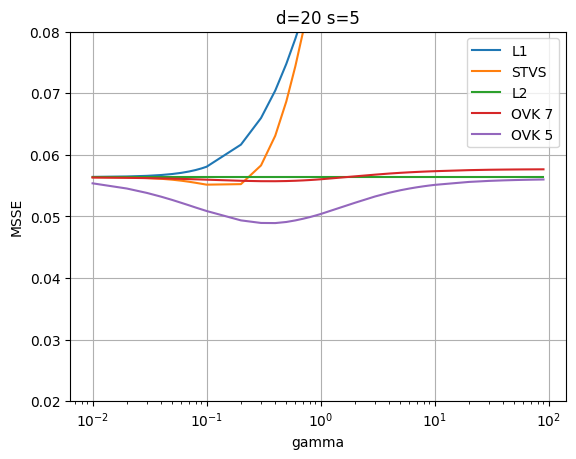

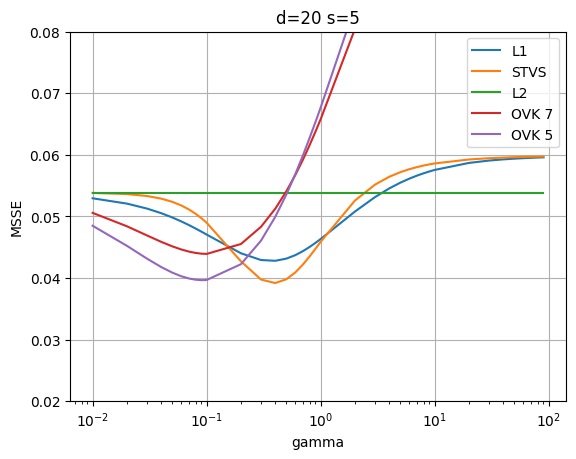

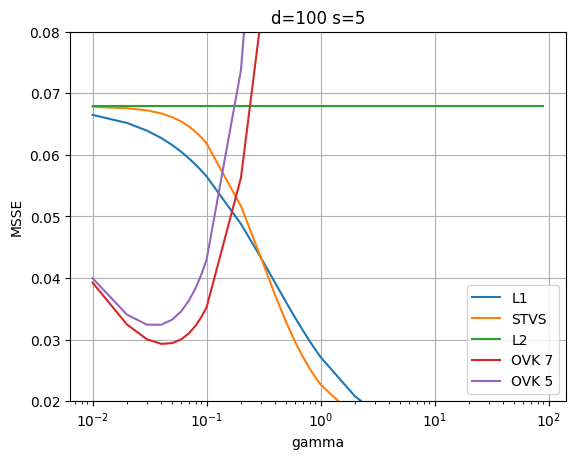

In [98]:
plt.plot(gammas, msse_L1_d_8, label='L1')
plt.plot(gammas, msse_STVS_d_8, label='STVS')
plt.plot(gammas, msse_L2_d_8, label='L2')
plt.plot(gammas, msse_ovk_7_d_8, label='OVK 7')
plt.plot(gammas, msse_ovk_5_d_8, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('MSSE')
plt.xscale('log')
plt.ylim(0.02,0.08)
plt.title('d=20 s=5')
plt.legend()
plt.grid(True)

plt.show()

plt.plot(gammas, msse_L1_d_20, label='L1')
plt.plot(gammas, msse_STVS_d_20, label='STVS')
plt.plot(gammas, msse_L2_d_20, label='L2')
plt.plot(gammas, msse_ovk_7_d_20, label='OVK 7')
plt.plot(gammas, msse_ovk_5_d_20, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('MSSE')
plt.xscale('log')
plt.ylim(0.02,0.08)
plt.title('d=20 s=5')
plt.legend()
plt.grid(True)

plt.show()

plt.plot(gammas, msse_L1_d_100, label='L1')
plt.plot(gammas, msse_STVS_d_100, label='STVS')
plt.plot(gammas, msse_L2_d_100, label='L2')
plt.plot(gammas, msse_ovk_7_d_100, label='OVK 7')
plt.plot(gammas, msse_ovk_5_d_100, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('MSSE')
plt.xscale('log')
plt.ylim(0.02,0.08)
plt.title('d=100 s=5')
plt.legend()
plt.grid(True)

plt.show()

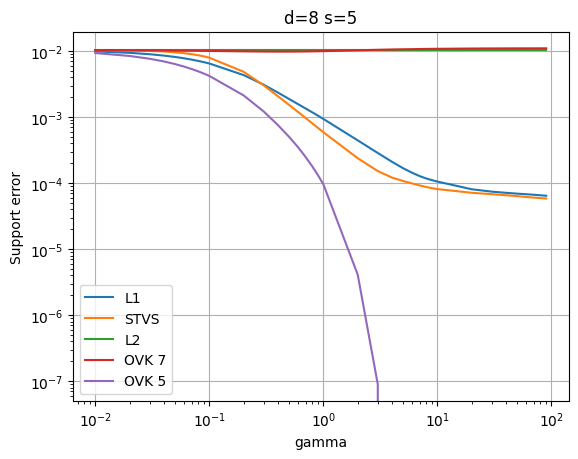

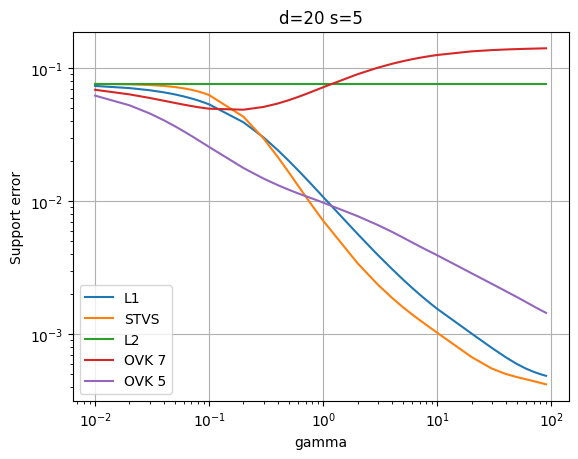

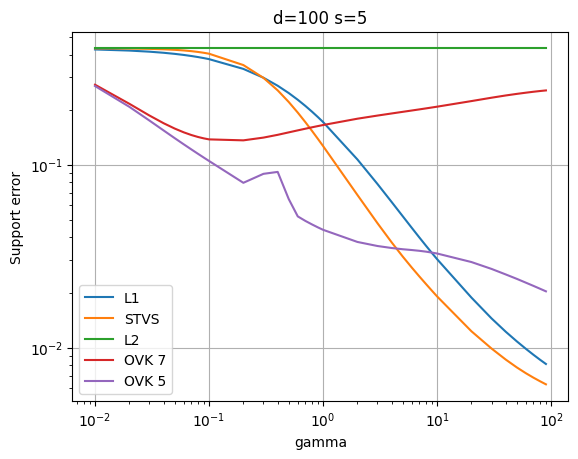

In [99]:
plt.plot(gammas, support_errors_L1_d_8, label='L1')
plt.plot(gammas, support_errors_STVS_d_8, label='STVS')
plt.plot(gammas, support_errors_L2_d_8, label='L2')
plt.plot(gammas, support_errors_ovk_7_d_8, label='OVK 7')
plt.plot(gammas, support_errors_ovk_5_d_8, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('Support error')
plt.xscale('log')
plt.yscale('log')
plt.title('d=8 s=5')
plt.legend()
plt.grid(True)

plt.show()

plt.plot(gammas, support_errors_L1_d_20, label='L1')
plt.plot(gammas, support_errors_STVS_d_20, label='STVS')
plt.plot(gammas, support_errors_L2_d_20, label='L2')
plt.plot(gammas, support_errors_ovk_7_d_20, label='OVK 7')
plt.plot(gammas, support_errors_ovk_5_d_20, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('Support error')
plt.xscale('log')
plt.yscale('log')
plt.title('d=20 s=5')
plt.legend()
plt.grid(True)

plt.show()

plt.plot(gammas, support_errors_L1_d_100, label='L1')
plt.plot(gammas, support_errors_STVS_d_100, label='STVS')
plt.plot(gammas, support_errors_L2_d_100, label='L2')
plt.plot(gammas, support_errors_ovk_7_d_100, label='OVK 7')
plt.plot(gammas, support_errors_ovk_5_d_100, label='OVK 5')

plt.xlabel('gamma')
plt.ylabel('Support error')
plt.xscale('log')
plt.yscale('log')
plt.title('d=100 s=5')
plt.legend()
plt.grid(True)

plt.show()

## Experiments with vaying dimention d and best gamma(d)

In [10]:
def grid_search(n, d, gammas):

    gammas = sorted([10**(j) * i for i in range(1,10) for j in range(-2,2)])

    costs_L1 = [ott.geometry.costs.ElasticL1(scaling_reg=gamma, matrix=None, orthogonal=False) for gamma in gammas]
    costs_STVS = [ott.geometry.costs.ElasticSTVS(scaling_reg=gamma, matrix=None, orthogonal=False) for gamma in gammas]
    costs_L2 = [ott.geometry.costs.PNormP(2) for gamma in gammas]
    costs_ovk_7 = [ott.geometry.costs.ElasticSqKOverlap(7, scaling_reg=gamma) for gamma in gammas]
    costs_ovk_5 = [ott.geometry.costs.ElasticSqKOverlap(5, scaling_reg=gamma) for gamma in gammas]

    best_MSSE_L1 = min(compute_metrics(costs_L1, n, d, s)[0])
    best_MSSE_STVS = min(compute_metrics(costs_STVS, n, d, s)[0])
    best_MSSE_L2 = min(compute_metrics(costs_L2, n, d, s)[0])
    best_MSSE_ovk_7 = min(compute_metrics(costs_ovk_7, n, d, s)[0])
    best_MSSE_ovk_5 = min(compute_metrics(costs_ovk_5, n, d, s)[0])

    return [best_MSSE_L1, best_MSSE_STVS, best_MSSE_L2, best_MSSE_ovk_7, best_MSSE_ovk_5]
    
    

In [11]:
n = 100
s=2

ds = jnp.logspace(jnp.log10(8), jnp.log10(1000), num=20, dtype=int)
gammas = sorted([10**(j) * i for i in range(1,10) for j in range(-2,2)])

best_MSSE_L1 = []
best_MSSE_STVS = []
best_MSSE_L2 = []
best_MSSE_ovk_7 = []
best_MSSE_ovk_5 = []

for d in tqdm(ds) :
    bests_MSE = grid_search(n, d, gammas)
    best_MSSE_L1.append(bests_MSE[0])
    best_MSSE_STVS.append(bests_MSE[1])
    best_MSSE_L2.append(bests_MSE[2])
    best_MSSE_ovk_7.append(bests_MSE[3])
    best_MSSE_ovk_5.append(bests_MSE[4])

100%|██████████| 20/20 [52:40<00:00, 158.02s/it]


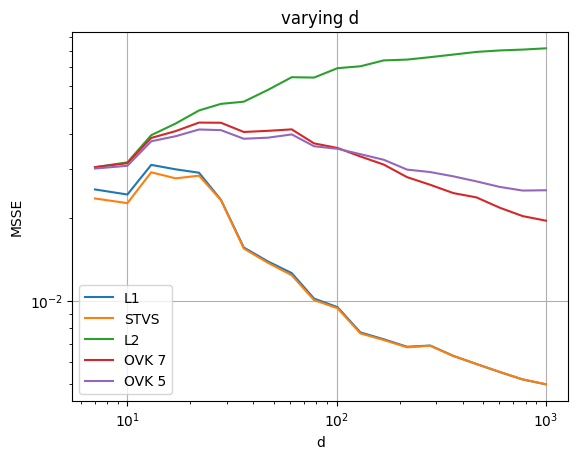

In [12]:
plt.plot(ds, best_MSSE_L1, label='L1')
plt.plot(ds, best_MSSE_STVS, label='STVS')
plt.plot(ds, best_MSSE_L2, label='L2')
plt.plot(ds, best_MSSE_ovk_7, label='OVK 7')
plt.plot(ds, best_MSSE_ovk_5, label='OVK 5')

plt.xlabel('d')
plt.ylabel('MSSE')
plt.xscale('log')
plt.yscale('log')
plt.title('varying d')
plt.legend()
plt.grid(True)

plt.show()